In [19]:
# Import libraries necessary for this project
import missingno as msno
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import norm, skew 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Allows the use of display() for DataFrames
from IPython.display import display 

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns',100)
pd.set_option('max_rows',100000)

# 데이터 숫자 소숫점 표시
pd.options.display.float_format = '{:.2f}'.format 

In [26]:
# 최초 데이터
raw_data1 = pd.read_csv('vehicles.csv')
raw_data1.shape

(509577, 25)

In [27]:
# 크롤링한 데이터
raw_data2 = pd.read_csv("final_vin_crawling.csv")
raw_data2.shape

(77578, 16)

In [100]:
# 최초 데이터 vin 값 기준, outer merge
raw_data = pd.merge(raw_data2, raw_data1, how='outer', on='vin')
raw_data.shape

(512828, 40)

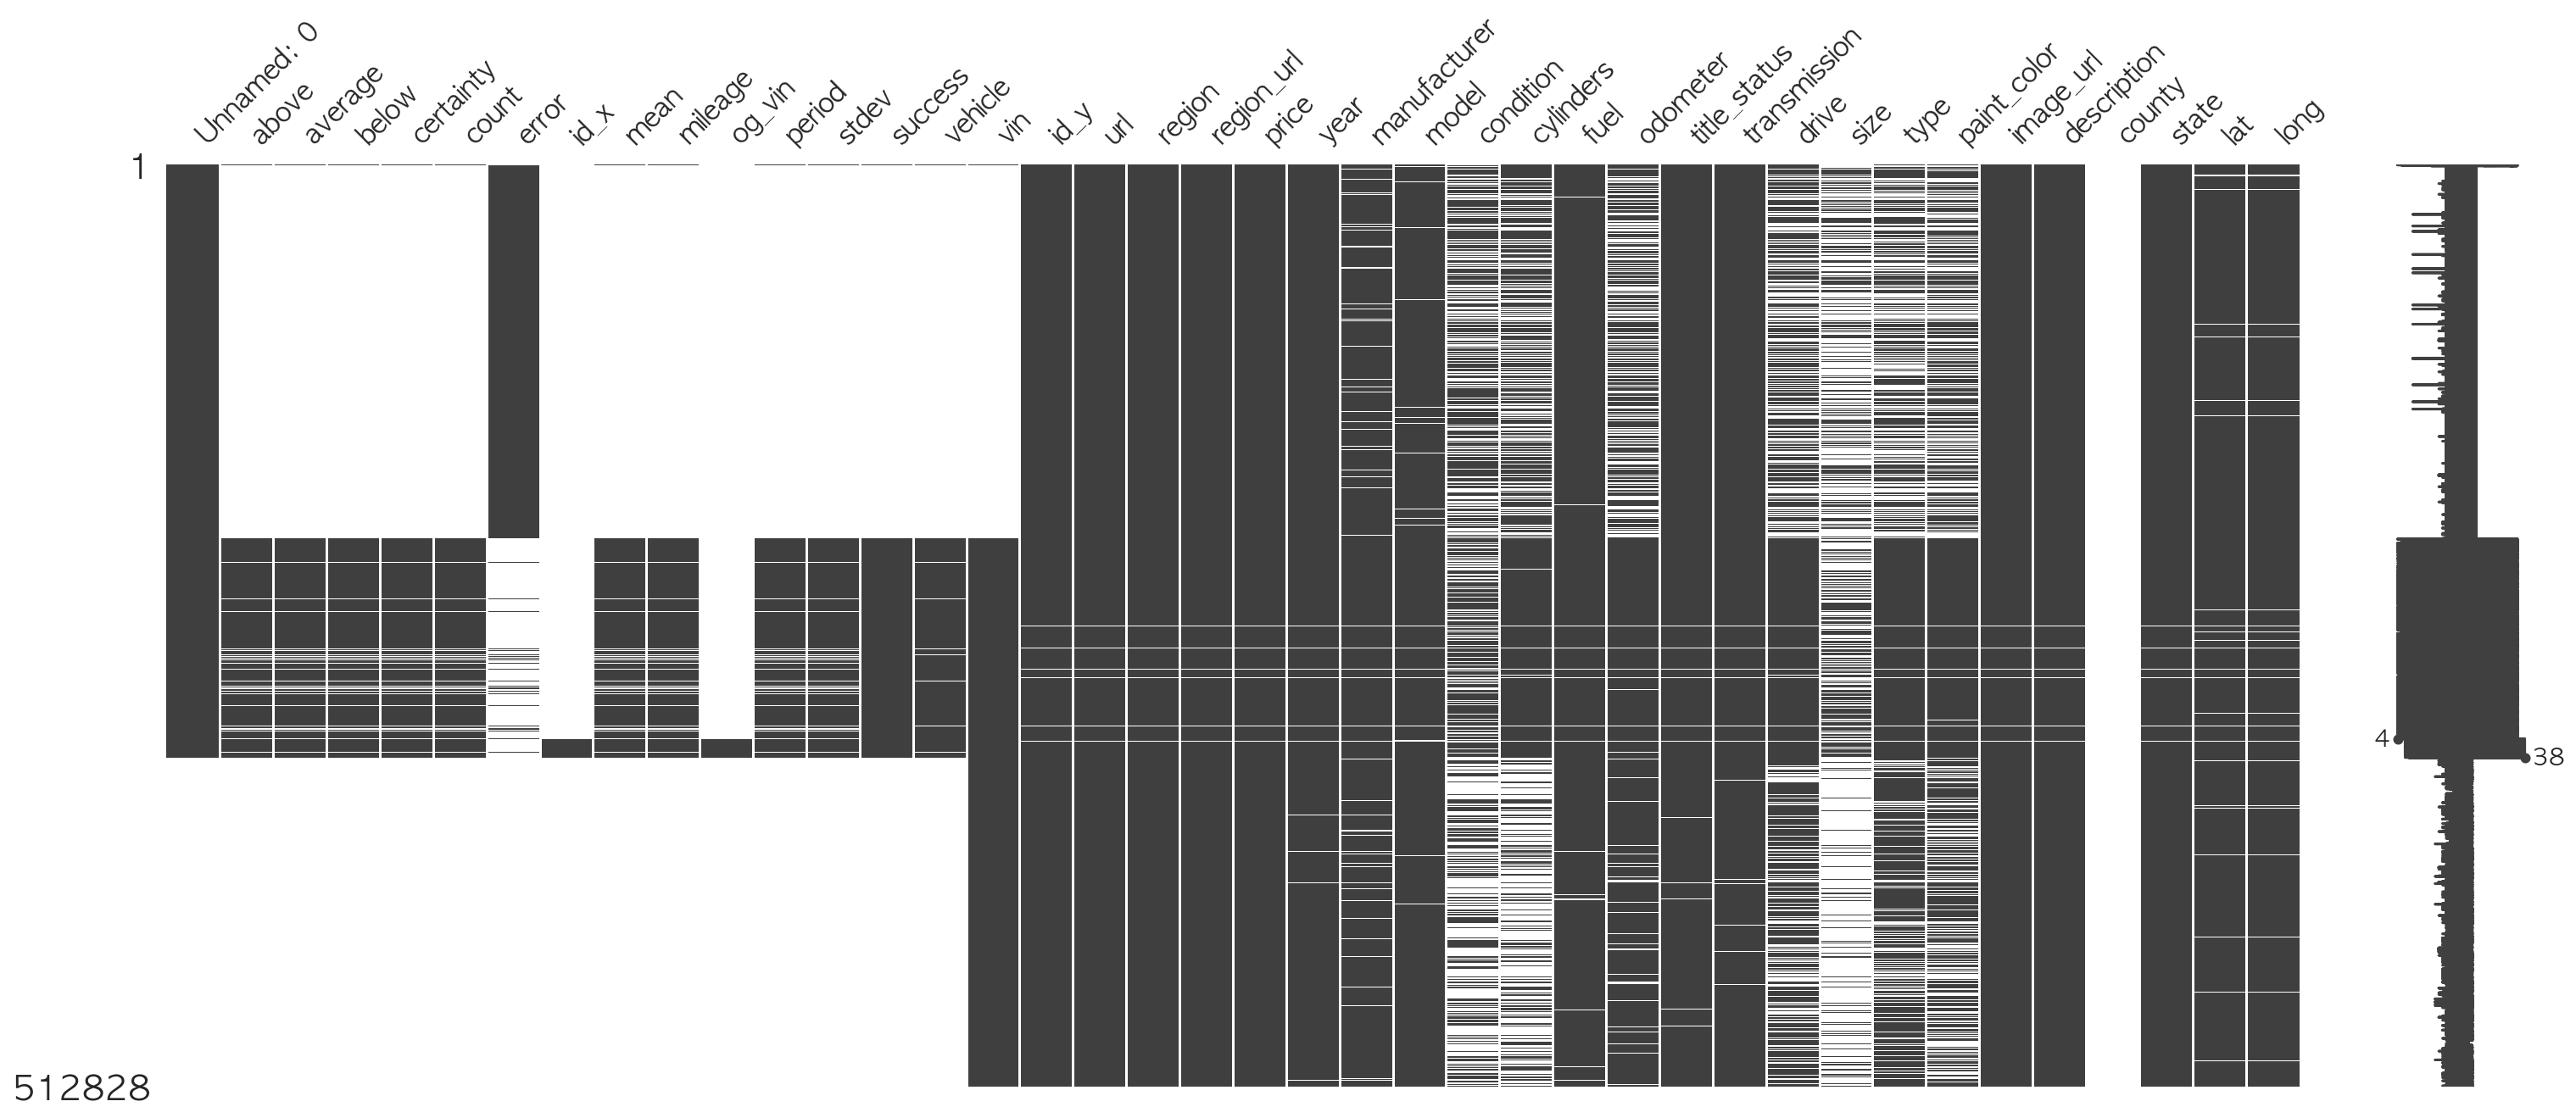

In [44]:
# 결측치 확인
msno.matrix(raw_data)
plt.show()

In [101]:
# 제외 항목 제거 
raw_data.drop(['county'], axis=1, inplace=True)
raw_data.shape

(512828, 39)

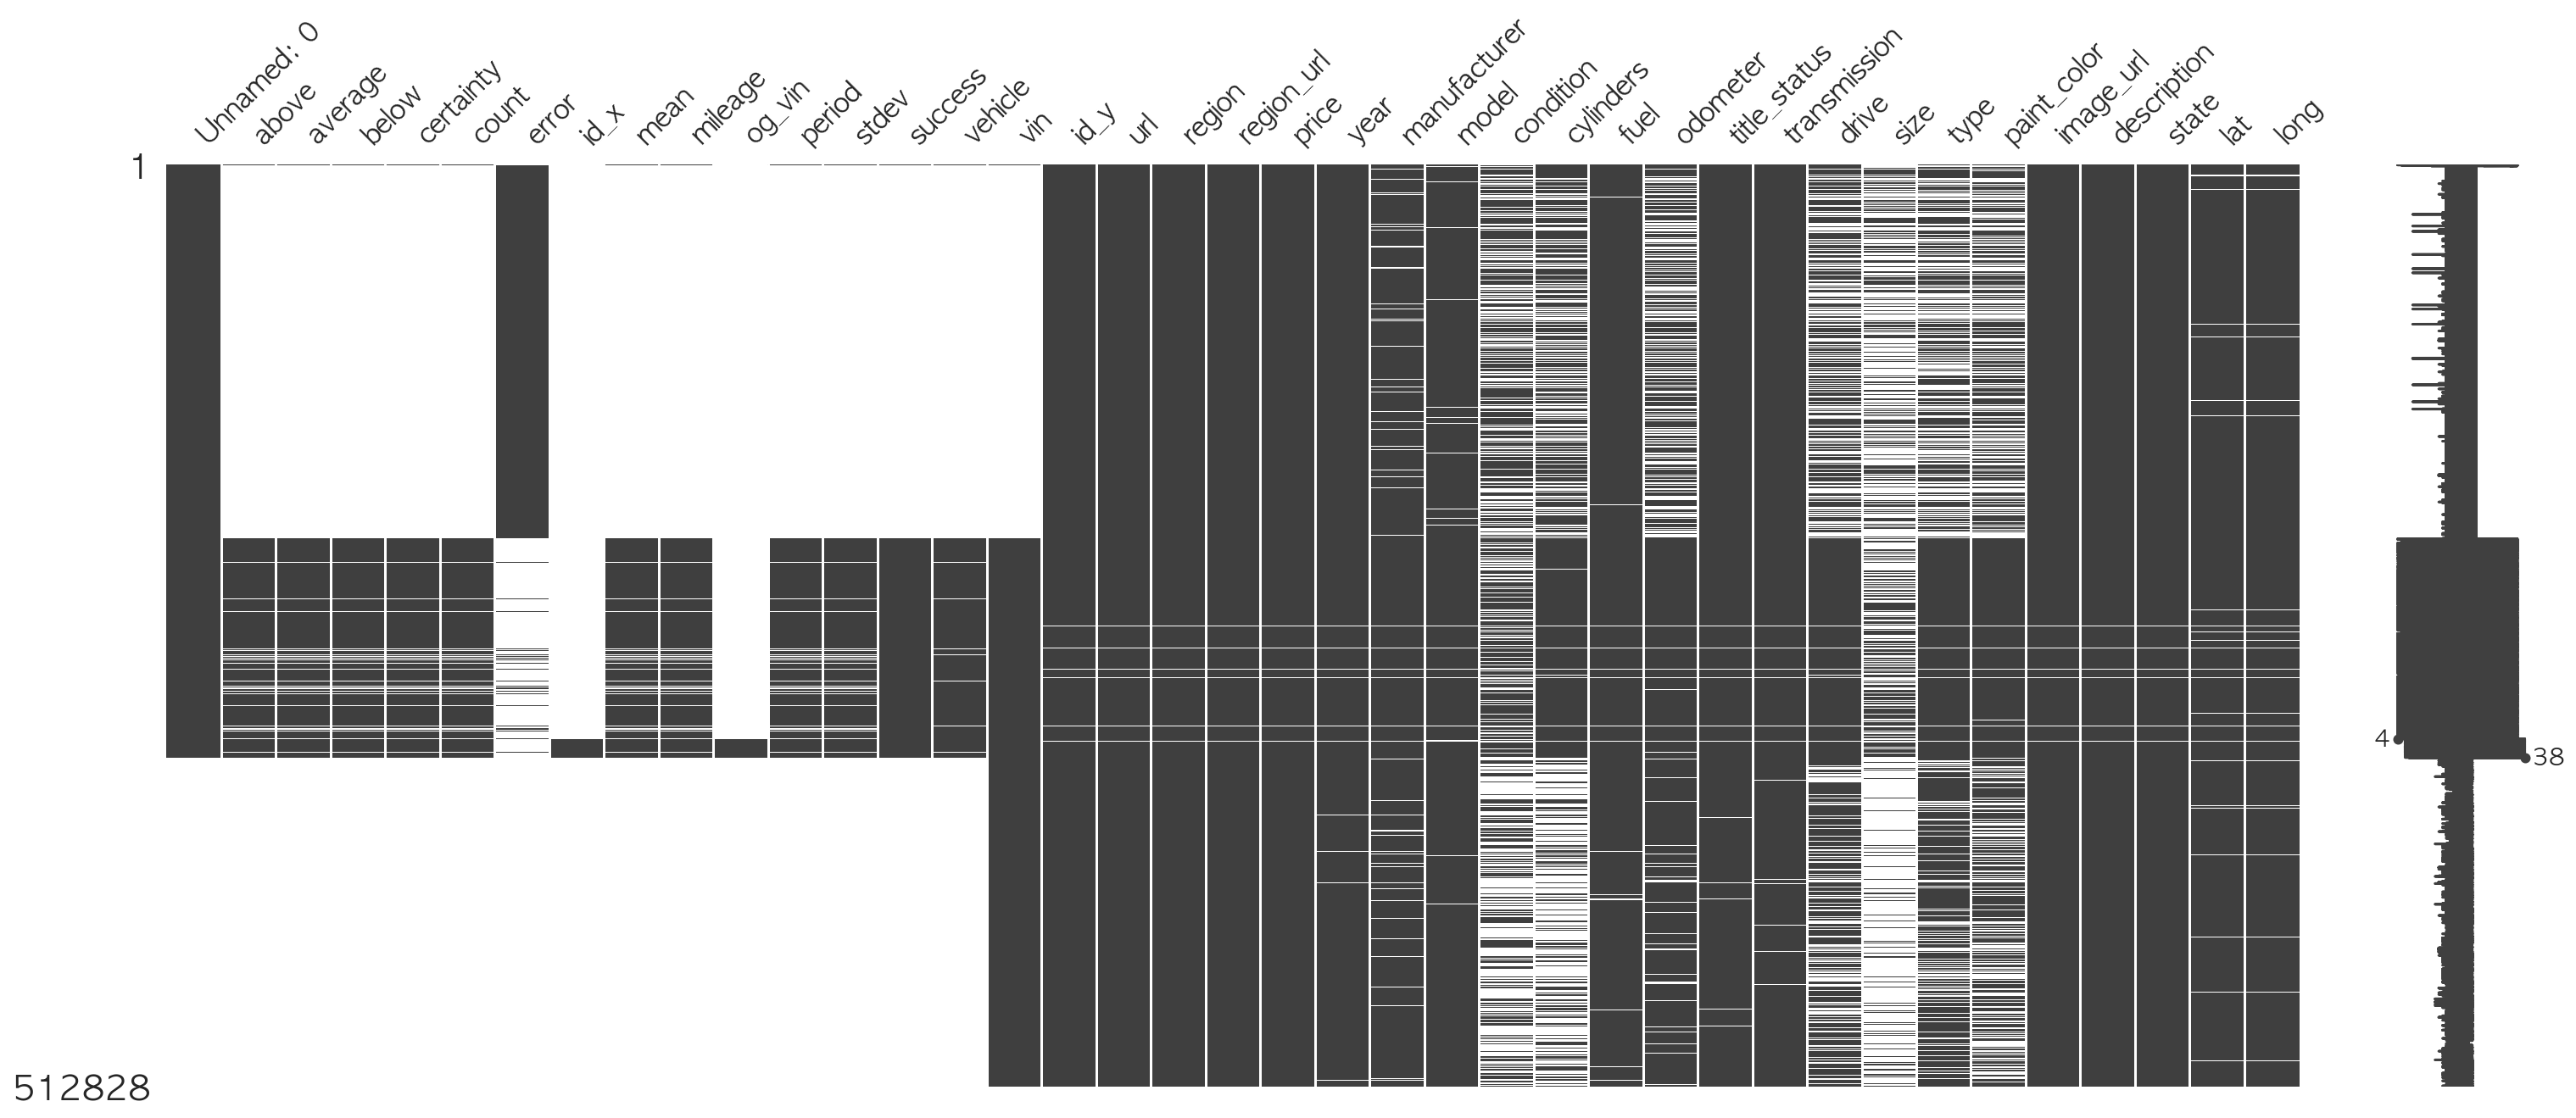

In [47]:
# 결측치 확인
msno.matrix(raw_data)
plt.show()

In [102]:
# vin 중복 제거 
raw_data = raw_data.loc[raw_data.drop_duplicates('vin', keep='first').index]
raw_data.shape

(183397, 39)

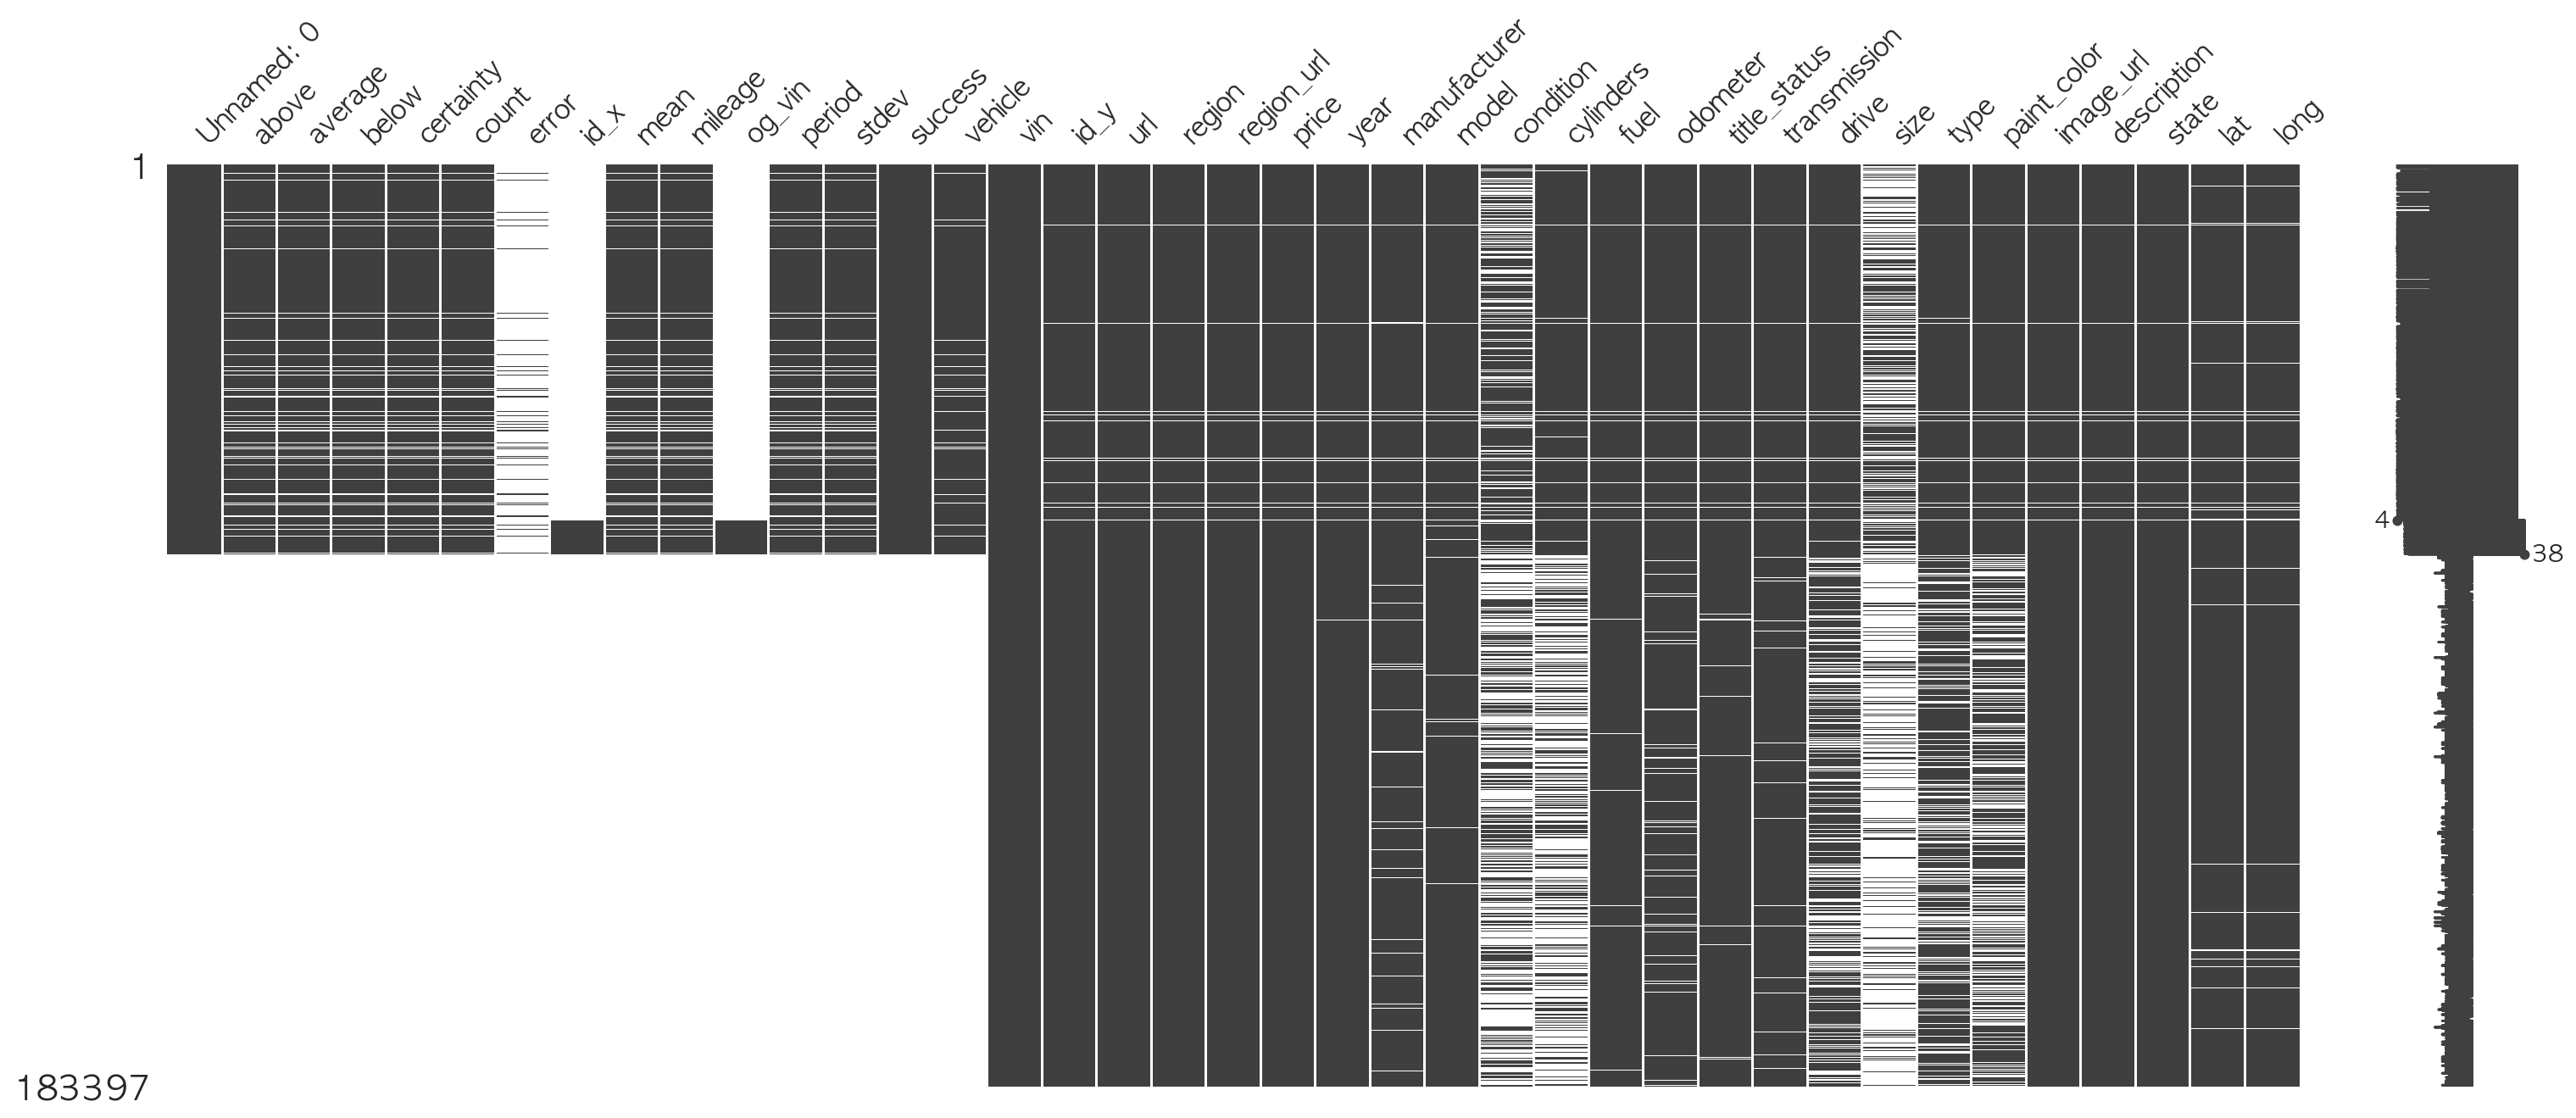

In [51]:
# 결측치 확인
msno.matrix(raw_data)
plt.show()

In [60]:
raw_data.columns

Index(['Unnamed: 0', 'above', 'average', 'below', 'certainty', 'count',
       'error', 'id_x', 'mean', 'mileage', 'og_vin', 'period', 'stdev',
       'success', 'vehicle', 'vin', 'id_y', 'url', 'region', 'region_url',
       'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'image_url', 'description', 'state', 'lat',
       'long'],
      dtype='object')

In [86]:
# 가격의 범위 지정
raw_data['fin_price'] = raw_data['price'][(raw_data['price'] >= raw_data['below']) & (raw_data['price'] <= raw_data['above'])]
raw_data.shape

(183397, 40)

In [87]:
# odometer와 mileage
raw_data['fin_odometer'] = raw_data['odometer'][raw_data['odometer'] == raw_data['mileage']]
raw_data[['odometer', 'mileage', 'fin_odometer']].shape

(183397, 3)

In [88]:
# 분석할 컬럼 추출
df1 = raw_data[['fin_price', 'year', 'fin_odometer', 'manufacturer', 'cylinders', \
                'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']]
df1.shape

(183397, 12)

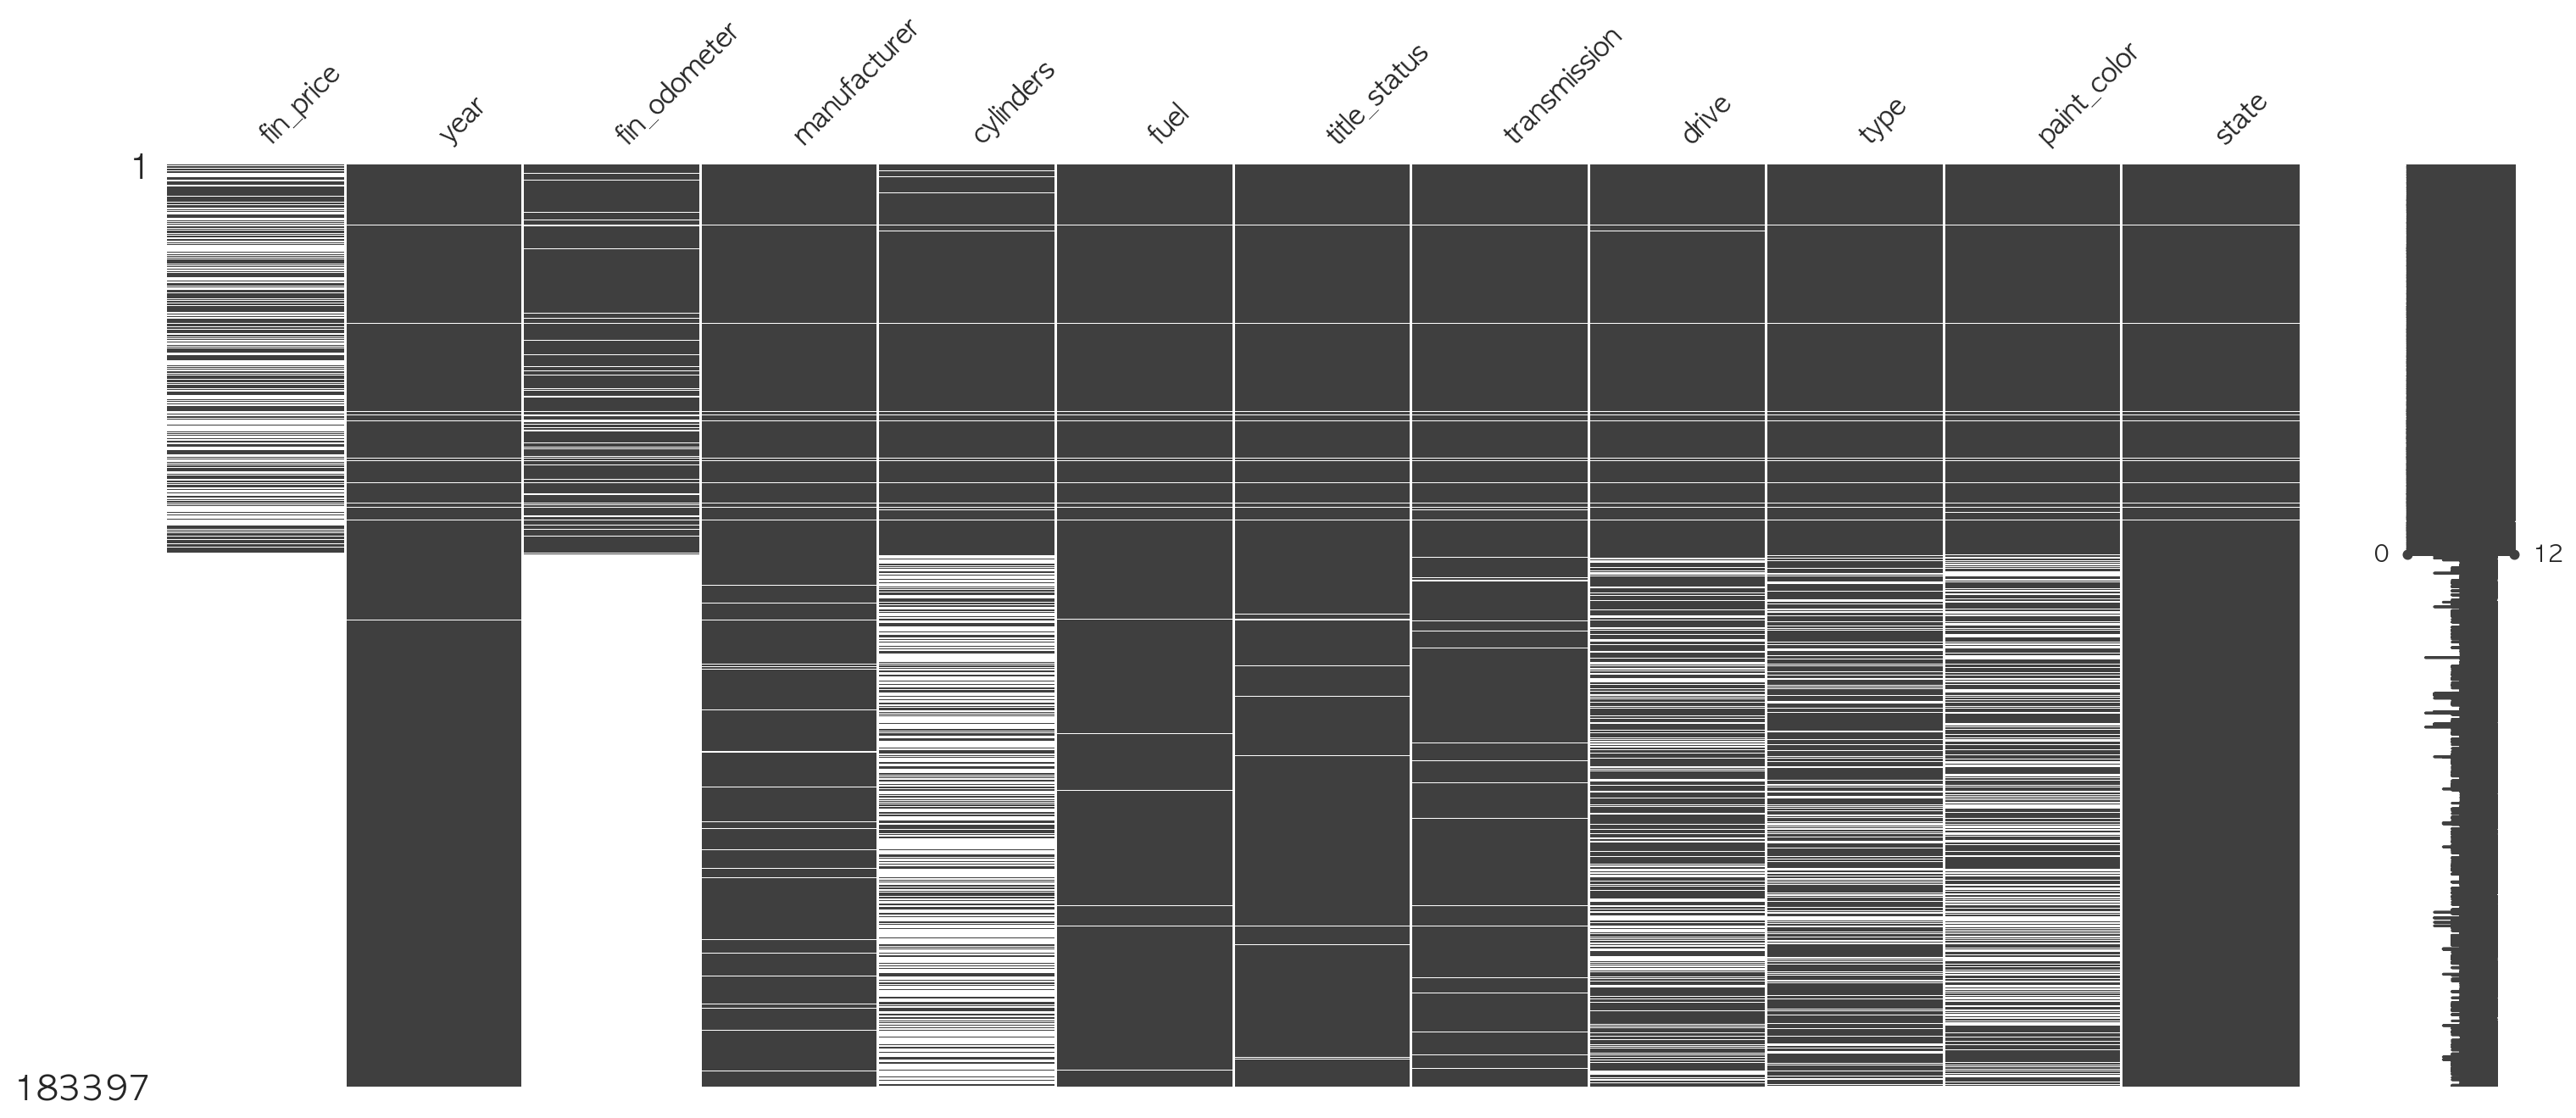

In [76]:
msno.matrix(df1)
plt.show()

In [89]:
# fin_price를 기준으로 결측 행 제거
df1 = df1[['fin_price', 'year', 'fin_odometer', 'manufacturer', 'cylinders', \
                'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']].dropna()
df1.shape

(41039, 12)

In [90]:
df1.tail()

,fin_price,year,fin_odometer,manufacturer,cylinders,fuel,title_status,transmission,drive,type,paint_color,state
330116,44513.00,2017.00,121648.00,chevrolet,8 cylinders,diesel,clean,automatic,4wd,truck,black,co
330117,45000.00,2018.00,28000.00,ram,6 cylinders,diesel,lien,automatic,4wd,pickup,white,in
330119,48255.00,2015.00,70000.00,rover,8 cylinders,gas,lien,automatic,4wd,SUV,black,fl
330120,49700.00,2018.00,20400.00,rover,4 cylinders,gas,clean,automatic,4wd,SUV,white,az
330122,60000.00,2017.00,41000.00,rover,6 cylinders,diesel,clean,automatic,4wd,SUV,white,ca


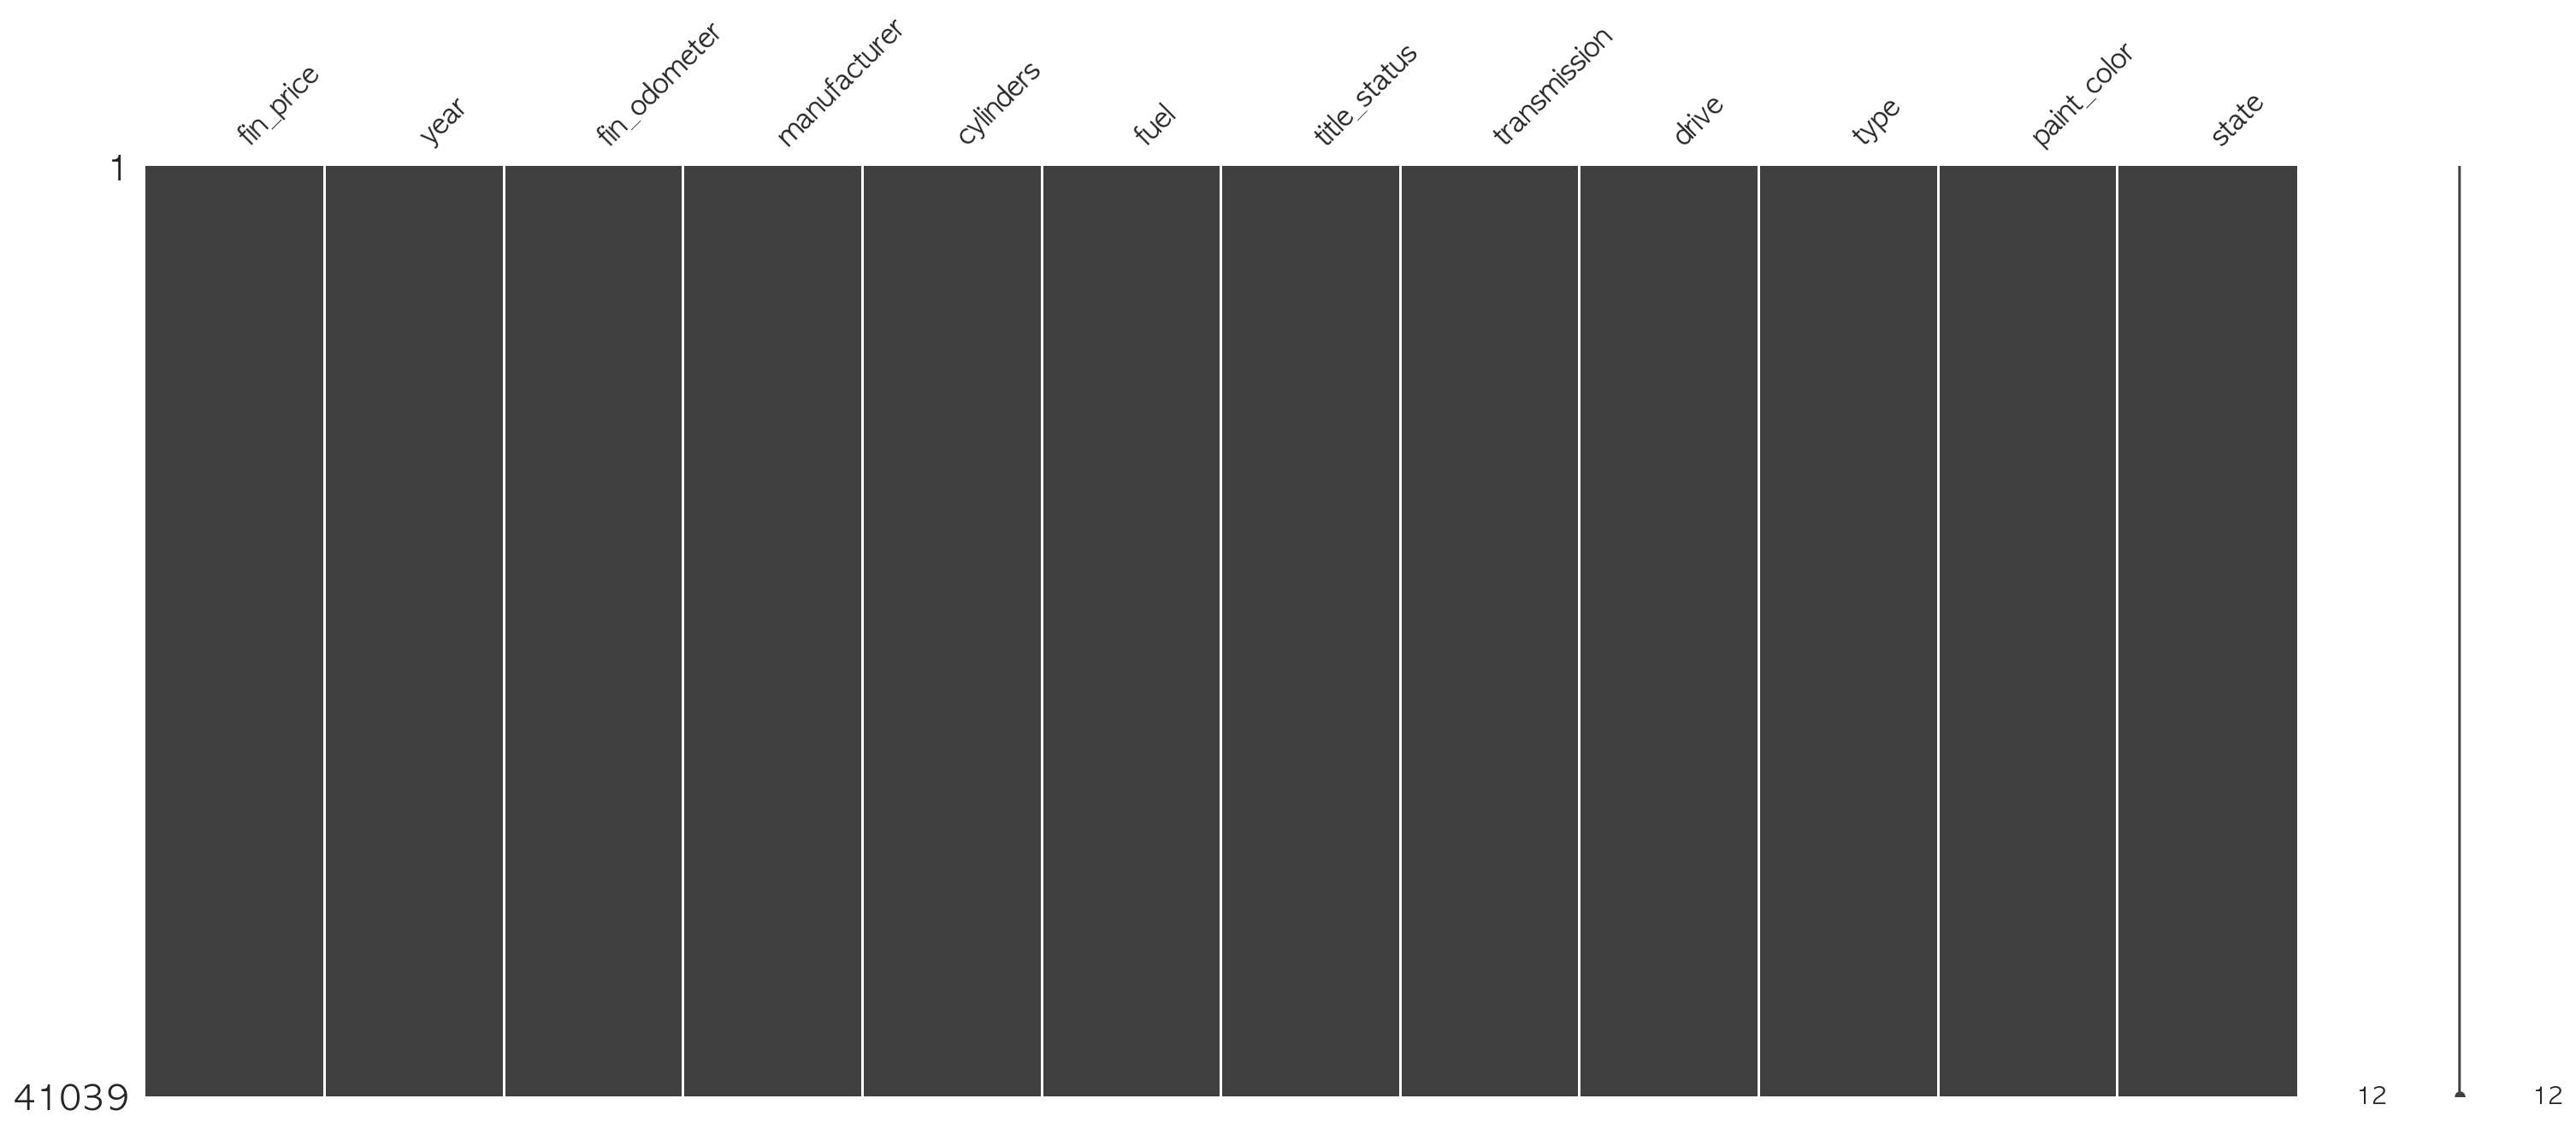

In [91]:
msno.matrix(df1)
plt.show()

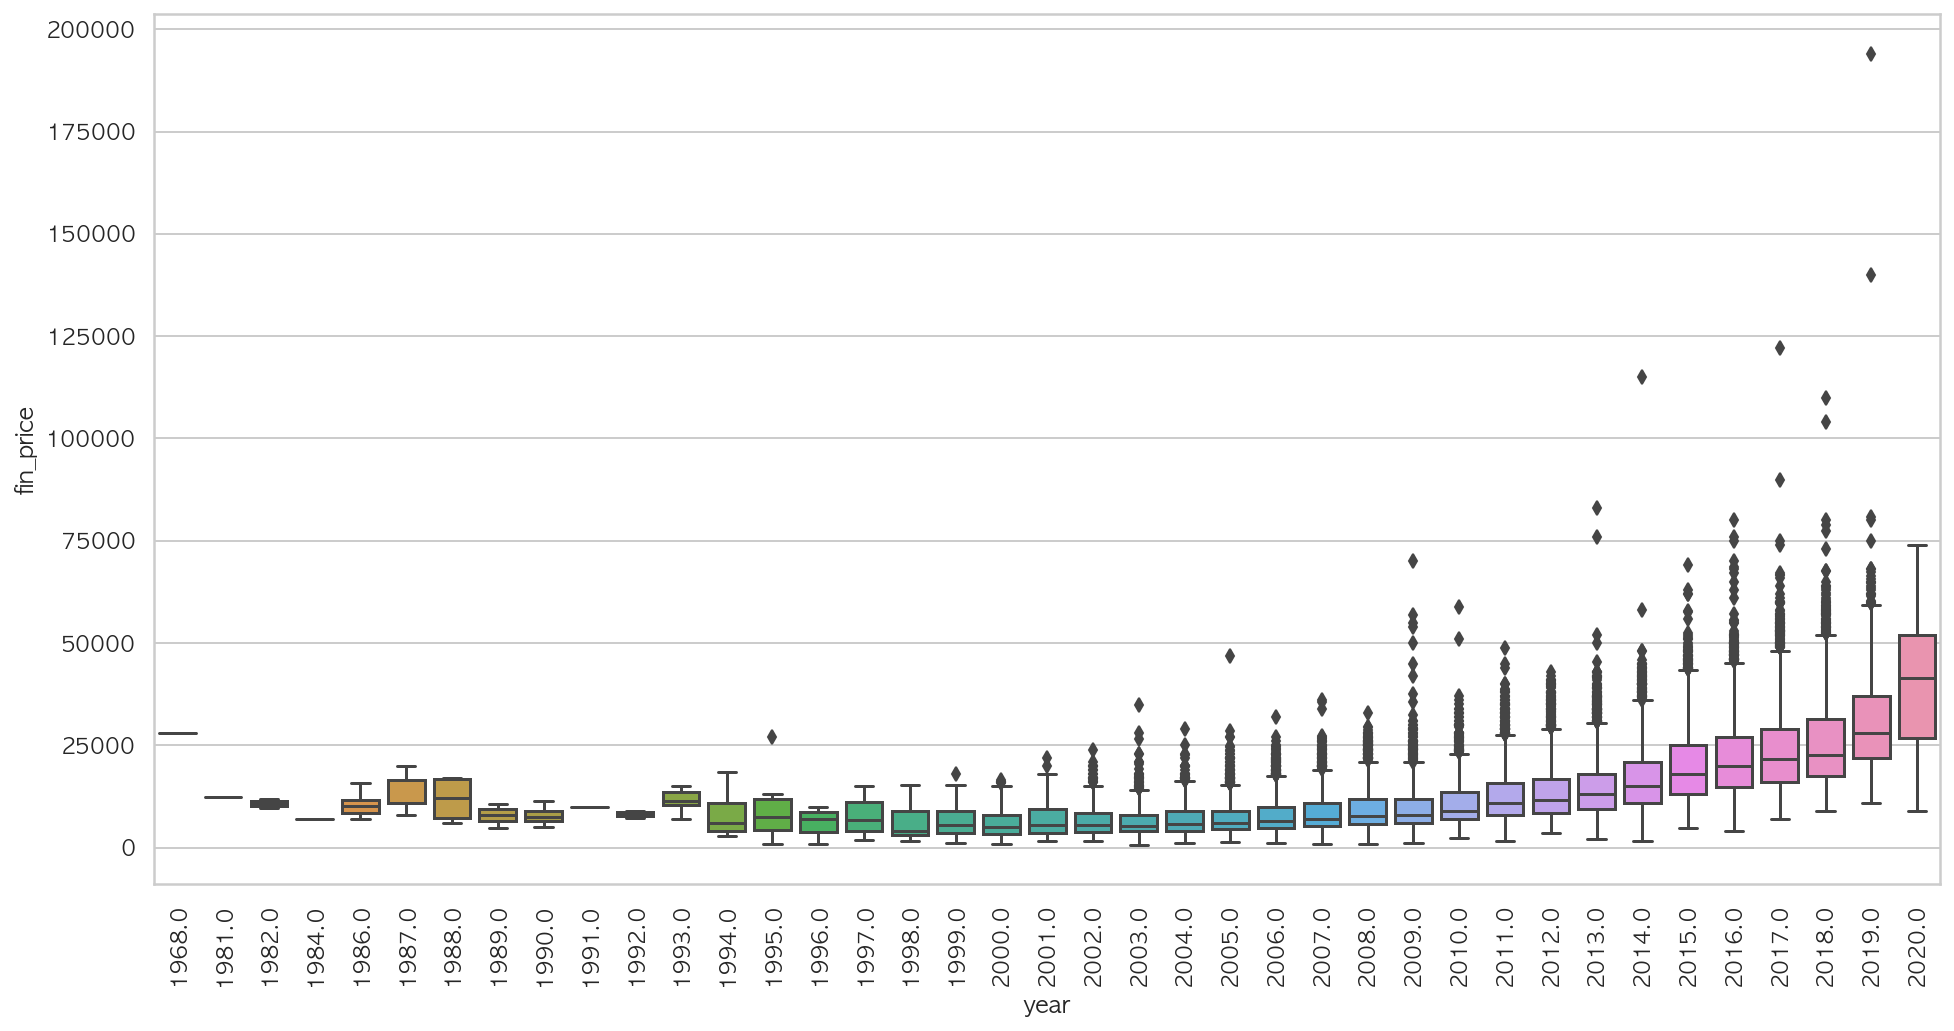

In [93]:
# 가격과 연도의 박스플롯
plt.figure(figsize=(16,8))
sns.boxplot(x="year", y="fin_price", data = df1)
plt.xticks(rotation=90)
plt.show()

In [95]:
# 축소랭크, 스케일링, train test split
from sklearn.model_selection import train_test_split

# df = raw_data
def get_model1(seed):
    df_train, df_test = train_test_split(df1, test_size=0.4, random_state=seed)
    model = sm.OLS.from_formula("np.log(fin_price) ~ scale(year) + C(manufacturer) \
+ C(cylinders) + C(fuel) + scale(fin_odometer) + C(title_status) + C(transmission) \
+ C(drive) + C(type) + C(paint_color) + C(state)", data=df_train)
    return df_train, df_test, model.fit()

df_train, df_test, result1 = get_model1(4)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(fin_price)   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1216.
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:48:14   Log-Likelihood:                 1354.3
No. Observations:               24623   AIC:                            -2447.
Df Residuals:                   24492   BIC:                            -1384.
Df Model:                         130                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

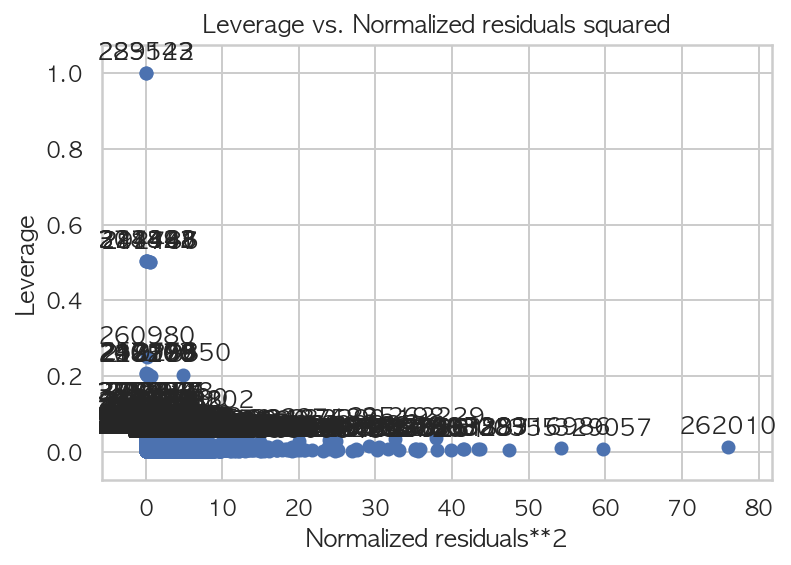

In [96]:
# cook's distance로 아웃라이어, 레버리지 값을 표시
sm.graphics.plot_leverage_resid2(result1)
plt.show()

In [97]:
# ANOVA(분산) 분석
sm.stats.anova_lm(result1)

,df,sum_sq,mean_sq,F,PR(>F)
C(manufacturer),36.00,1285.65,35.71,677.25,0.00
C(cylinders),7.00,529.98,75.71,1435.79,0.00
C(fuel),4.00,222.10,55.53,1052.99,0.00
C(title_status),4.00,44.35,11.09,210.29,0.00
C(transmission),2.00,114.39,57.19,1084.63,0.00
C(drive),2.00,428.38,214.19,4061.90,0.00
C(type),12.00,255.50,21.29,403.77,0.00
C(paint_color),11.00,155.78,14.16,268.56,0.00
C(state),50.00,296.06,5.92,112.29,0.00
scale(year),1.00,4344.42,4344.42,82387.54,0.00


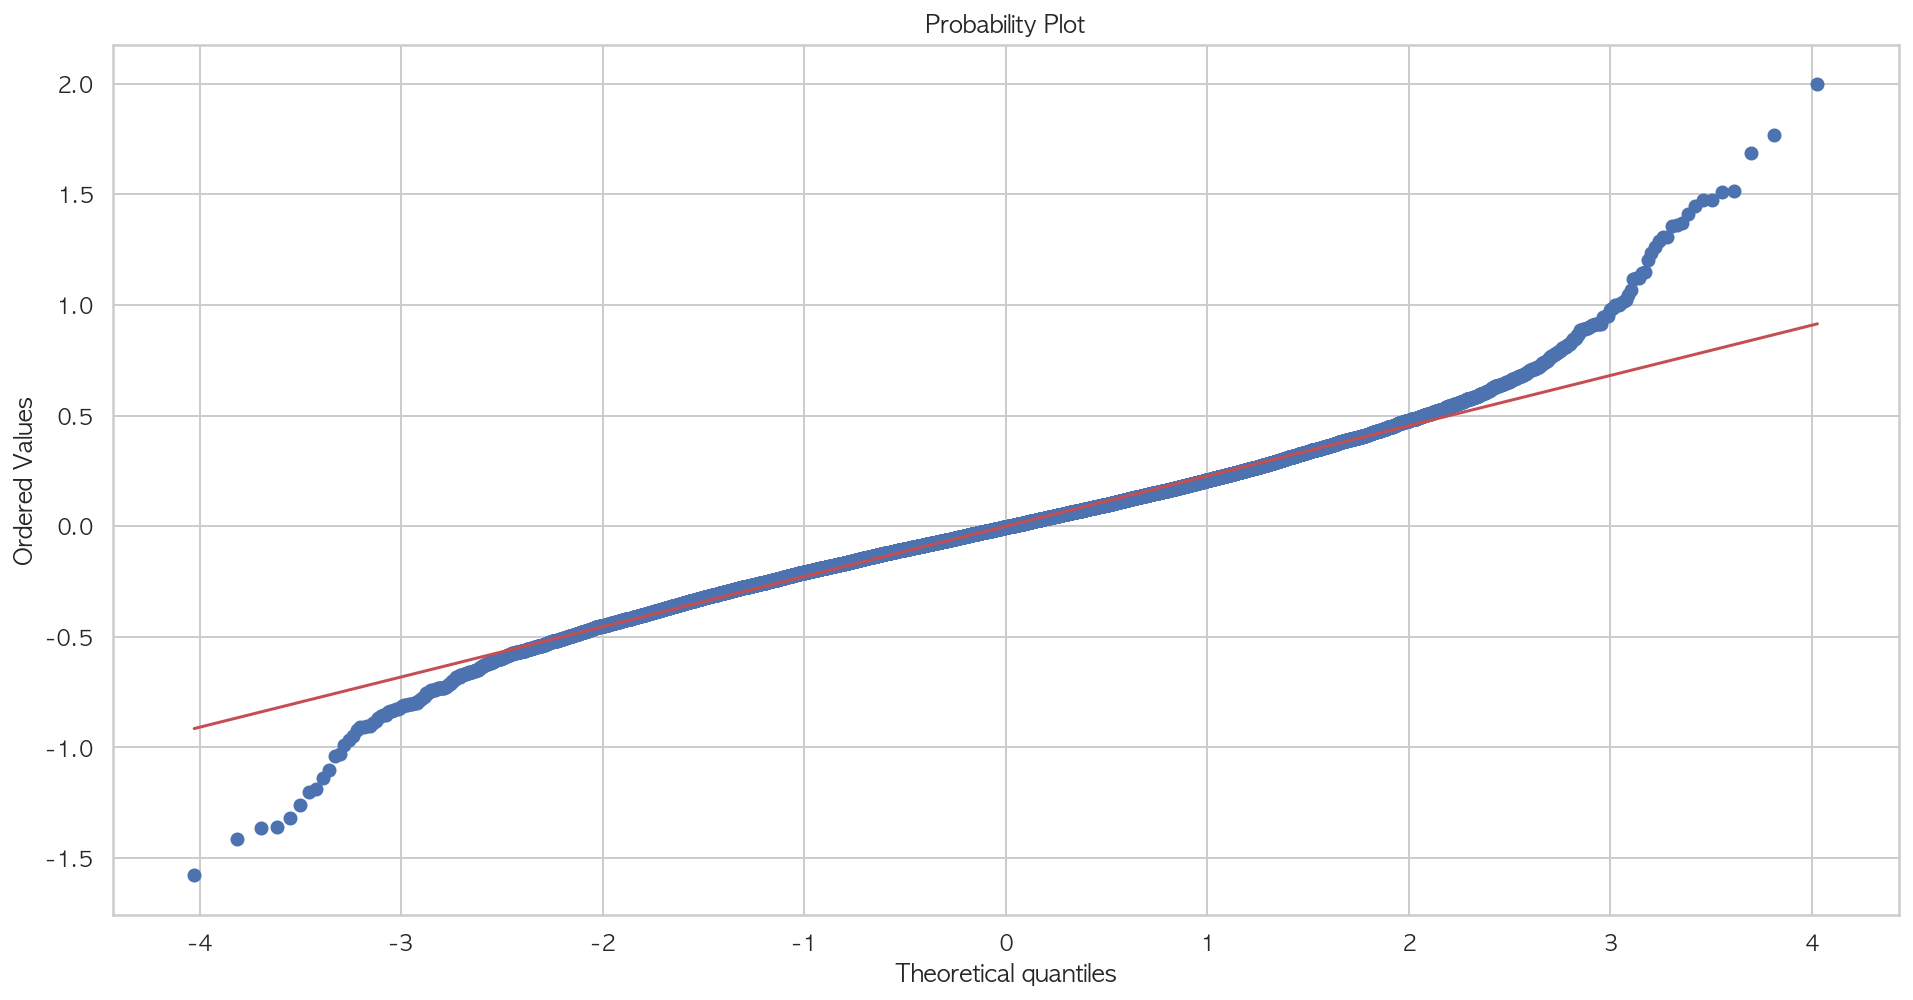

In [98]:
# Q-Q플롯: 정규분포
plt.figure(figsize=(16,8))
sp.stats.probplot(result1.resid, plot=plt)
plt.show()

In [99]:
# 교차검증 반복
from sklearn.model_selection import KFold

cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]
    
    model = sm.OLS.from_formula("np.log(fin_price) ~ scale(year) + C(manufacturer) \
+ C(cylinders) + C(fuel) + scale(fin_odometer) + C(title_status) + C(transmission) \
+ C(drive) + C(type) + C(paint_color) + C(state)", data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.fin_price - pred) ** 2).sum()
    tss = ((df_test.fin_price - df_test.fin_price.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print('학습 R2 = {:.8f}, 검증 R2 = {:.8f}'.format(result.rsquared, rsqueard))

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'ferrari' does not match any of the expected levels (expected: ['acura', 'alfa-romeo', ..., 'volkswagen', 'volvo'])
    np.log(fin_price) ~ scale(year) + C(manufacturer) + C(cylinders) + C(fuel) + scale(fin_odometer) + C(title_status) + C(transmission) + C(drive) + C(type) + C(paint_color) + C(state)
                                      ^^^^^^^^^^^^^^^